# Exercise 2

Required python packages

In [15]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from IPython.display import Image, display

# Utility & Logging
import os
import time
import sys
import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm

# Core numerical processing
import numpy as np
from numba import jit, prange

In [16]:
np.random.seed(42)

DATA_PATH = 'data/ex2'
MEDIA_PATH = 'media/ex2'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MEDIA_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

log = Logger('Set 2 Logger')
fh = FileHandler(f'{LOG_PATH}/ex2_1_1.log', mode='w', level=INFO, bubble=True)
h = StreamHandler(sys.stdout, level=WARNING)
fh.push_application()
h.push_application()

Check for CUDA availability for GPU compute

In [17]:
from numba import cuda

CUDA = False

try:
    CUDA = cuda.detect()
    log.info('CUDA is available.')
except ImportError:
    log.info('CUDA is not available. Uses CPU for computations instead.')

Core functionality for solving Laplace equation

In [18]:
def sor_basic(c: np.ndarray, omega: float, obj: np.ndarray, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the simple iterative (inefficient) Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0]  # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        for i in range(0, Nx):
            for j in range(0, Nx-1):  # exclude y=Nx source
                if obj[i, j] == 0:
                    if j == 0:
                        c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                            (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                    else:
                        c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                            (c[(i+1) % Nx, j] + c[i-1, j] +
                                c[i, j+1] + c[i, j-1]), 0)
                else:
                    c[i, j] = 0.0

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # log.debug(f'Converged after {n} iterations using omega={omega}.')
            break

    return c, n, converged

@jit(nopython=True, parallel=True)
def sor_parallel(c: np.ndarray, omega: float, obj: np.ndarray, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the red-black parallel Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0]  # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        # Red points
        for i in prange(0, Nx):
            for j in range(0, Nx-1): # exclude y=Nx source
                if (i + j) % 2 == 0:
                    if obj[i, j] == 0:
                        # note use of negative indices and modulo for boundary cases
                        # max to ensure non-negative concentrations
                        if j == 0: # j-1 excluded
                            c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                        else:
                            c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1]), 0)
                    else:
                        c[i, j] = 0.0

        # Black points | same comments as above
        for i in prange(0, Nx):
            for j in range(0, Nx-1):
                if (i + j) % 2 == 1:
                    if obj[i, j] == 0:
                        if j == 0:
                            c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                        else:
                            c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1]), 0)
                    else:
                        c[i, j] = 0.0

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # log.debug(f'Converged after {n} iterations using omega={omega}.')
            break

    return c, n, converged


# doesn't work with numba
# def has_converged(c_new, c_old, epsilon) -> bool:
#     '''Check if the SOR solver has converged to a stead state solution.'''
#     return np.max(np.abs(c_new - c_old)) < epsilon

Visualization utility

In [19]:
def plot_concentration(c, title, filename, save=True):
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(c, 3), origin='lower')
    plt.colorbar(label='Concentration')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_object(obj, title, filename, save=True):
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(obj, 3), origin='lower', cmap='binary')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_object_on_concentration(c, obj, title, filename, save=True):
    plt.figure(figsize=(5, 4), layout='tight')
    cmap = plt.get_cmap('viridis')
    img = plt.imshow(np.rot90(c, 3), origin='lower', cmap=cmap)
    plt.colorbar(label='Concentration')

    # Paint object white
    rgba_img = cmap(np.rot90(c, 3))
    rgba_img[np.rot90(obj, 3) == 1, :3] = 1
    plt.imshow(rgba_img, origin='lower')

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

Test run of SOR implementation

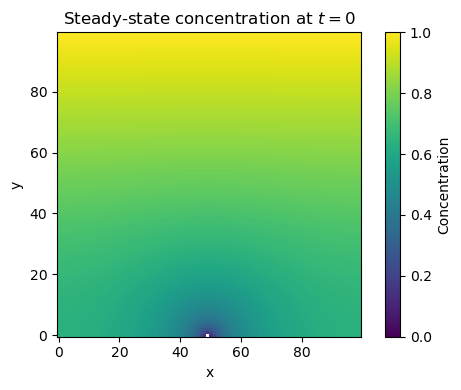

In [20]:
Nx = 100
omega = 1.8

c = np.zeros((Nx, Nx))
c[:, -1] = 1.0
c_init = c.copy()

obj = np.zeros((Nx, Nx), dtype=int)  # growing object
obj[Nx//2, 0] = 1
c[Nx//2, 0] = 0.0

c, sor_iters, converged = sor_parallel(c, omega, obj)
plot_object_on_concentration(c, obj, f'Steady-state concentration at $t=0$', f'initial_concentration_dla')

## Computing performance comparison (iterative vs. parallel)

Compare speed of solving Laplace equation using simple iterative SOR vs. optimized parallel scheme

In [21]:
gridsizes = np.insert(np.logspace(1, 3, 15, base=10, dtype=int), 0, 5)
times = np.zeros((len(gridsizes), 2))
sor_iters = np.zeros((len(gridsizes), 2))

if os.path.exists(f'{DATA_PATH}/comparison_times.csv') and os.path.exists(f'{DATA_PATH}/comparison_sor_iters.csv'):
    times = np.loadtxt(f'{DATA_PATH}/comparison_times.csv', delimiter=',', skiprows=1)
    sor_iters = np.loadtxt(f'{DATA_PATH}/comparison_sor_iters.csv', delimiter=',', skiprows=1)
else:
    for s, sor_solver in tqdm(enumerate([sor_basic, sor_parallel]), total=2, desc='Testing solvers', leave=False, unit='solver'):
        for i, Nx in tqdm(enumerate(gridsizes), total=len(gridsizes), desc=f'Simulating grid sizes', leave=False, unit='sim'):
            if sor_solver is sor_basic and Nx > 200:  # Skip basic solver for grid sizes over 200, takes too long
                times[i, s] = np.nan
                continue

            c = np.zeros((Nx, Nx))
            c[:, -1] = 1.0
            
            obj = np.zeros((Nx, Nx), dtype=int)  # growing object
            obj[Nx//2, 0] = 1
            c[Nx//2, 0] = 0.0

            start = time.time()
            c, sor_iters, converged = sor_solver(c, omega, obj)
            end = time.time()

            sor_iters[i, s] = sor_iters
            times[i, s] = end - start

    np.savetxt(f'{DATA_PATH}/comparison_times.csv', np.asarray(times), delimiter=',', header='basic,parallel', comments='')
    np.savetxt(f'{DATA_PATH}/comparison_sor_iters.csv', np.asarray(sor_iters), delimiter=',', header='basic,parallel', comments='')

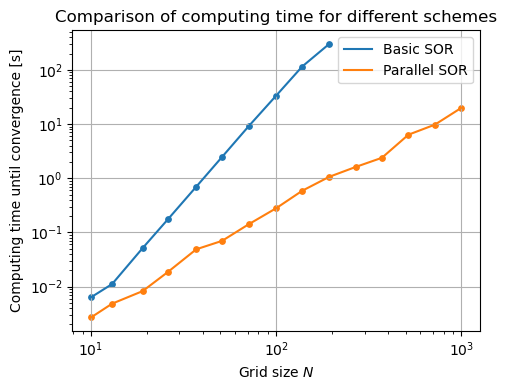

In [22]:
plt.figure(figsize=(5, 4), layout='tight')
# Skip first run as it has side effects of compilation for `sor_parallel`
plt.plot(gridsizes[1:], times[1:, 0], label='Basic SOR', color='tab:blue')
plt.scatter(gridsizes[1:], times[1:, 0], color='tab:blue', s=15)
plt.plot(gridsizes[1:], times[1:, 1], label='Parallel SOR', color='tab:orange')
plt.scatter(gridsizes[1:], times[1:, 1], color='tab:orange', s=15)
plt.xlabel('Grid size $N$')
plt.ylabel('Computing time until convergence [s]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Comparison of computing time for different schemes')
plt.savefig(f'{MEDIA_PATH}/comparison_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

## Diffusion-Limited Aggregation

Implementation of growth model simulation using `sor_parallel`

In [23]:
def simulate_dla_growth_model(Nt, Nx=100, max_sor_iter=1_000, omega=1.7, eta=1.0, epsilon=1e-6, seed_pos='lower center', init_optimize=True, show_tqdm=True):
    '''Simulates the Diffusion Limited Aggregation (DLA) growth model using a parallized SOR scheme.
    Returns the concentration matrix, the object matrix and the number of iterations until the end of the simulation.
    '''
    # Growth object
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    c = setup_concentration_matrix(Nx, seed_pos_idx, init_optimize)

    obj = np.zeros((Nx, Nx), dtype=int)
    obj[*seed_pos_idx] = 1
    log.debug(f'Size of object after initialization: {np.count_nonzero(obj)}.')

    growth_candidates = set()
    growth_candidates = add_growth_candidates(growth_candidates, obj=obj, new_idx=seed_pos_idx, Nx=Nx, skip_removal=True)

    times = np.zeros((Nt))
    sor_iters = np.zeros((Nt), dtype=int)

    iterator = tqdm(range(Nt), desc='Simulating DLA run', leave=False) if show_tqdm else range(Nt)
    for iter in iterator:
        start = time.time()
        c, sor_iter, converged = sor_parallel(
            c, omega, obj, epsilon, max_sor_iter)
        end = time.time()

        sor_iters[iter] = sor_iter
        times[iter] = end - start
        
        if not converged:
            raise ValueError(f'SOR convergence for DLA time step {iter} not reached after {sor_iter} iterations. ' + 
                             'Increase `max_iterations` or decrease `epsilon`.')
        else:
            log.debug(f'SOR converged after {sor_iter} iterations.')

        candidate_probabilities = get_candidate_probabilities(
            c, growth_candidates, eta)
        
        list_growth_candidates = list(growth_candidates)
        
        chosen_idx = np.random.choice(len(growth_candidates), p=candidate_probabilities)
        log.debug(f'Chosen index: {chosen_idx} of list with value {list_growth_candidates[chosen_idx]}.')

        selected_candidate_idx = list_growth_candidates[chosen_idx]
        log.debug(f'Selected candidate: {list_growth_candidates[chosen_idx]} with p={candidate_probabilities[chosen_idx]:.3f}.')

        # Update growth_candidates
        growth_candidates = add_growth_candidates(growth_candidates, obj=obj, new_idx=selected_candidate_idx, Nx=Nx)

        obj[*selected_candidate_idx] = 1
        log.debug(f'Size of object after iteration {iter}: {np.count_nonzero(obj)}.')

    return c, obj, sor_iters, times
    

def setup_concentration_matrix(Nx, seed_pos_idx, init_optimize):
    c = np.zeros((Nx, Nx))
    c[:, -1] = 1  # top is source

    # Optimization: initial guess for stable concentration profile using analytical solution
    if init_optimize:
        y = np.linspace(0, 1, Nx)
        for i, y_i in enumerate(y):
            c[:, i] = y_i

    c[*seed_pos_idx] = 0

    return c


def get_seed_position(Nx, seed_pos: str):
    arg_list = seed_pos.lower().split(' ')

    if len(arg_list) == 0 or len(arg_list) == 1 and arg_list[0] != 'center':
        raise ValueError('Invalid seed position. Please provide positioning for both x and y coordinates or use "center".')
    elif len(arg_list) == 1 and arg_list[0] == 'center':
        return (Nx//2, Nx//2)

    seed_pos_h_dict = {
        'left': 0,
        'center': Nx//2,
        'right': Nx-1
    }

    x = seed_pos_h_dict.get(arg_list[-1], -1)
        
    seed_pos_v_dict = {
        'lower': 0,
        'center': Nx//2,
        'upper': Nx-1
    }

    y = seed_pos_v_dict.get(arg_list[0], -1)

    if x == -1 or y == -1:
        raise ValueError('Invalid seed position. Please provide valid positioning for both x and y coordinates or use "center".')

    return (x, y)

def add_growth_candidates(growth_candidates: set, obj: np.ndarray, new_idx: tuple, Nx: int, skip_removal=False):
    '''Utility functionality to add the growth candidates to the list of candidates, remembering previous states and minimize re-checking. Efficient solution.'''
    i, j = new_idx
    # Remove newly added growth object
    if not skip_removal:
        growth_candidates.remove(new_idx)

    # Add von Neumann neighbors of the object
    if obj[(i-1) % Nx, j] == 0:
        growth_candidates.add(((i-1 % Nx), j))
    if obj[(i+1) % Nx, j] == 0:
        growth_candidates.add(((i+1) % Nx, j))
    if j > 0 and obj[i, j-1] == 0:
        growth_candidates.add((i, j-1))
    if j < Nx-1 and obj[i, j+1] == 0:
        growth_candidates.add((i, j+1))

    if len(growth_candidates) == 0:
        log.warning(f'No more growth candidates found.')
    else:
        log.debug(f'Found {len(growth_candidates)} growth candidates.')

    return growth_candidates

def get_candidates_bruteforce(obj):
    '''Utility functionality to get all van Neumann (Manhattan distance = 1) neighbors (growth candidates) of the object.
    Returns a numpy array of the indices of the growth candidates. Inefficient solution.'''
    obj_indices = np.argwhere(obj == 1)
    Nx = obj.shape[0] # assume square
    growth_candidates = set()

    # consider all von Neumann neighbors of the object that aren't the object as candidates
    for i, j in obj_indices:
        if obj[i-1, j] == 0:
            growth_candidates.add((i-1, j))
        if obj[(i+1) % Nx, j] == 0:
            growth_candidates.add(((i+1) % Nx, j))
        if j > 0 and obj[i, j-1] == 0:
            growth_candidates.add((i, j-1))
        if j < Nx-1 and obj[i, j+1] == 0:
            growth_candidates.add((i, j+1))

    if len(growth_candidates) == 0:
        log.warning(f'No more growth candidates found.')
    else:
        log.debug(f'Found {len(growth_candidates)} growth candidates.')

    return np.array(list(growth_candidates))


def get_candidate_probabilities(c, growth_candidates, eta):
    '''Utility functionality to get the probability of growth for each candidate based on its concentration.'''
    candidate_probabilities = np.zeros(len(growth_candidates))

    if eta < 0:
        raise ValueError('Eta must be greater equals zero.')
    elif eta > 2:
        log.warning('Eta is greater than 2. Usually 0 <= eta <= 2.')

    for i, (x, y) in enumerate(growth_candidates):
        candidate_probabilities[i] = c[x, y]**eta

    sum_probabilities = np.sum(candidate_probabilities)

    if np.any(candidate_probabilities < 0):
        log.debug('Negative growth probabilities found. Should be impossible as `soc_parallel` should be preventing this.')
        log.debug(f'Growth candidate matrix:\n{growth_candidates}')
        log.debug(f'Candidate probabilities:\n{candidate_probabilities}')
        raise ValueError('Negative growth probabilities found.')

    if sum_probabilities <= 0:
        raise ValueError(
            'Sum of probabilities is (less than or equal) zero but neighbors were found. Either all neighbors have concentration exactly 0 (unlikely) or there is another issue. Please check the concentration matrix.')
    
    candidate_probabilities /= sum_probabilities

    return candidate_probabilities


def select_best_omega_for_sor(omega_values, epsilon, c_init, seed_pos='lower center', max_iterations=10_000):
    '''Finds the best relaxation parameter omega for SOR'''

    best_omega = 0
    least_iter = max_iterations

    # Growth object
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    obj = np.zeros((Nx, Nx), dtype=int)
    obj[*seed_pos_idx] = 1
    log.debug(f'Number of non-zero object elements after initialization: {np.count_nonzero(obj)}.')

    for omega in tqdm(omega_values):
        c = c_init.copy()
        c, n_iter, converged = sor_parallel(c, omega, obj, epsilon, max_iterations)
        if converged and n_iter < least_iter:
            least_iter = n_iter
            best_omega = omega
            c_converged = c.copy()
        # else:
        #     log.debug(f'Convergence not reached for omega={omega}.')
    if best_omega == 0:
        raise ValueError(f'Unable to converge using provided omega values {omega_values} within {max_iterations} steps. ' + 
                         'Please provide larger omega range and/or maximum iteration count to reach convergence.')
    return c_converged, best_omega, least_iter

## Effect of DLA parameter $\eta$

Explore effect of DLA parameter $\eta$ on the shape of the final object in DLA

In [1]:
omega = 1.9
etas = [0.0, 0.5, 1.0, 1.5, 2.0]
Nt = 500
Nx = 100
max_sor_iter = 10_000

show_locally = []

for eta in tqdm(etas, desc='Simulating & plotting across eta range', leave=False, unit='sim'):
    title = f'Concentration at $t={Nt}$ with $\\eta = {eta}$'
    filename = f'final_concentration_dla_iters_{Nt}_iters_eta_{eta}'
    if not os.path.exists(f'{MEDIA_PATH}/{filename}.png'):
        c, obj, sor_iters, times = simulate_dla_growth_model(Nt=Nt, Nx=Nx, max_sor_iter=max_sor_iter, omega=omega, eta=eta, init_optimize=True)
        plot_object_on_concentration(c, obj, title, filename)
    else:
        show_locally.append(f'{MEDIA_PATH}/{filename}.png')

for path in show_locally:
    display(Image(filename=path, width=450))

NameError: name 'tqdm' is not defined

# Choice of $\omega$ parameter for SOR performance

Calculation of time/iterations needed for SOR averaged across $N$ runs. Load if already calculated and saved prior for selected $N$

In [35]:
omegas = np.concatenate((np.linspace(1.0, 1.9, 10), np.array([1.95])))
eta = 1.0
Nt = 250
Nx = 100
max_sor_iter = 50_000 # increase max iterations to enable suboptimal omegas to convergence
N = 25 # number of runs to average over

times_file_mean = f'{DATA_PATH}/omega_{N}_runs_{Nt}_iters_times.csv'
sor_iters_file_mean = f'{DATA_PATH}/omega_{N}_runs_{Nt}_iters_sor_iters.csv'

nd_times_mean = np.zeros((len(omegas), Nt))
nd_sor_iters_mean = np.zeros((len(omegas), Nt))

if os.path.exists(times_file_mean) and os.path.exists(sor_iters_file_mean):
    nd_times_mean = np.loadtxt(times_file_mean, delimiter=',')
    nd_sor_iters_mean = np.loadtxt(sor_iters_file_mean, delimiter=',')
else:
    pbar = tqdm(enumerate(omegas), total=len(omegas)*N, desc='Simulating across omega ranges', unit='sim', leave=False)
    for i, omega in pbar:
        acc_sor_iters = np.zeros((Nt, N))
        acc_times = np.zeros((Nt, N))
        for _ in range(N):
            c, obj, sor_iters, times = simulate_dla_growth_model(Nt=Nt, Nx=Nx, max_sor_iter=max_sor_iter, omega=omega, eta=eta, init_optimize=True, show_tqdm=False)
            acc_sor_iters[:, i] = sor_iters
            acc_times[:, i] = times
            pbar.update(1)
        mean_sor_iters = np.mean(acc_sor_iters, axis=1)
        mean_times = np.mean(acc_times, axis=1)
        log.debug(f'Mean iters for run: {mean_sor_iters}')
        log.debug(f'Mean times for run: {mean_times}')
        nd_times_mean[i] = mean_times
        nd_sor_iters_mean[i] = mean_sor_iters

    # Save the arrays to the files
    omega_str = ','.join([f'omega_{o:.2f}' for o in omegas])
    np.savetxt(times_file_mean, nd_times_mean, delimiter=',')
    np.savetxt(sor_iters_file_mean, nd_sor_iters_mean, delimiter=',')


Visualize

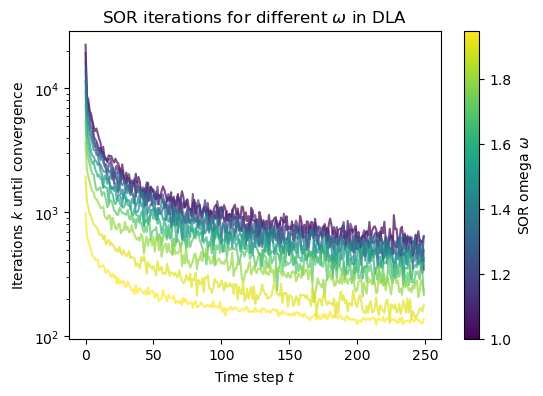

In [36]:
t = np.arange(Nt)

# For plotting purposes
nd_sor_iters_mean[nd_sor_iters_mean == 0] = np.nan

fig, ax = plt.subplots(figsize=(6, 4))
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=omegas.min(), vmax=omegas.max())

for i, omega in enumerate(omegas):
    color = cmap(norm(omega))
    ax.plot(t, nd_sor_iters_mean[i, :], color=color, alpha=0.7)

ax.set_xlabel('Time step $t$')
ax.set_ylabel('Iterations $k$ until convergence')
ax.set_yscale('log')

# Colorbar mapping
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='SOR omega $\\omega$')

ax.set_title(f'SOR iterations for different $\\omega$ in DLA')
fig.savefig(f'{MEDIA_PATH}/omega_iterations_{N}_samples.png', dpi=300, bbox_inches='tight')
plt.show()